## makemore: part 5

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

/home/barbara/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read in all the words
words = open('../data/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
Xte[:10]

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 13],
        [ 0,  0,  0,  0,  0,  0, 13, 21],
        [ 0,  0,  0,  0,  0, 13, 21, 19],
        [ 0,  0,  0,  0, 13, 21, 19, 20],
        [ 0,  0,  0, 13, 21, 19, 20,  1],
        [ 0,  0, 13, 21, 19, 20,  1,  6],
        [ 0, 13, 21, 19, 20,  1,  6,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 18]])

In [7]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [8]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


In [9]:
torch.manual_seed(42); # seed rng for reproducibility

In [10]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [11]:
model.layers[6].weight[:10]

tensor([[ 0.0343,  0.0071, -0.0357,  ...,  0.0353, -0.0215, -0.0500],
        [ 0.0518,  0.0974,  0.0533,  ..., -0.0409,  0.0462,  0.0280],
        [-0.0428, -0.0553,  0.0870,  ..., -0.0410,  0.0481,  0.0540],
        ...,
        [ 0.0353, -0.0009,  0.0467,  ...,  0.0087,  0.0745, -0.0192],
        [-0.0476,  0.1458, -0.0733,  ..., -0.0469,  0.0375,  0.0568],
        [ 0.0033, -0.1016,  0.0195,  ..., -0.1191, -0.0547,  0.1081]],
       grad_fn=<SliceBackward0>)

In [12]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
b=0
for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # if i % 10000 == 0: # print every once in a while
  #   print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  if(i % (max_steps//20) == 0):
        b+=1
        print(f"{i}- {i/max_steps*100:3.3}% complete - loss: {loss.item()}")
    
  lossi.append(loss.log10().item())



0- 0.0% complete - loss: 3.3167154788970947
10000- 5.0% complete - loss: 2.0576305389404297
20000- 10.0% complete - loss: 2.0723214149475098
30000- 15.0% complete - loss: 2.513370990753174
40000- 20.0% complete - loss: 2.147610902786255
50000- 25.0% complete - loss: 1.7835685014724731
60000- 30.0% complete - loss: 2.2591822147369385
70000- 35.0% complete - loss: 1.933072566986084
80000- 40.0% complete - loss: 1.6874719858169556
90000- 45.0% complete - loss: 2.039499044418335
100000- 50.0% complete - loss: 1.7735919952392578
110000- 55.0% complete - loss: 1.9569201469421387
120000- 60.0% complete - loss: 1.746492862701416
130000- 65.0% complete - loss: 1.8126134872436523
140000- 70.0% complete - loss: 1.7405569553375244
150000- 75.0% complete - loss: 1.7466140985488892
160000- 80.0% complete - loss: 1.880555272102356
170000- 85.0% complete - loss: 1.62660551071167
180000- 90.0% complete - loss: 1.6476343870162964
190000- 95.0% complete - loss: 1.8555388450622559


In [13]:
model.layers[3].running_mean[:10]

tensor([[[-0.7846,  0.8272, -0.2684, -0.8240,  1.6680,  2.5558, -2.9262,
          -0.9758,  0.2905, -1.6110,  1.9428,  0.0285,  1.5274,  0.1448,
          -1.0551, -0.0693, -0.3105,  0.5683, -0.1739,  1.5220,  0.4345,
           0.8329, -0.8888,  0.3645, -0.3219,  1.0535,  0.8350, -0.1219,
          -2.3343, -1.4504, -1.9306, -0.1367,  1.7226,  0.0533,  0.4895,
           0.7402,  0.4684, -0.9621, -0.8464,  0.9073, -1.7920, -0.5720,
          -1.8289, -0.2365,  1.7588,  0.9340, -0.9492,  0.4106, -1.4997,
          -0.6906,  3.0010,  0.7764,  1.0957,  0.6564, -1.2978, -0.9158,
           0.9479, -0.6406, -0.3606,  0.7398,  0.7814,  0.7297, -0.1490,
           0.7268,  1.1333,  0.3973, -0.4385, -1.0195, -1.3193, -0.4797,
           0.2721,  0.2282, -1.4128,  0.5747, -2.4889, -0.3355,  0.2449,
           0.6314,  0.8434,  1.5788,  0.0799,  1.6405,  1.8315,  0.8944,
          -0.4057,  1.3396,  1.3433, -0.5380,  0.9973, -0.2667,  1.1408,
           1.3442,  1.6702, -0.8796, -1.0813, -0.18

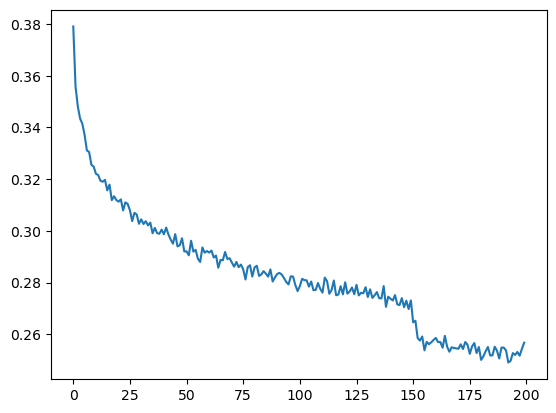

In [14]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [15]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [22]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7690281867980957
val 1.993652105331421


### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993


In [17]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

arlij.
chetta.
heago.
rocklei.
hendrix.
jamylie.
broxin.
denish.
anslibt.
marianah.
astavia.
annayve.
aniah.
jayce.
nodiel.
remita.
niyelle.
jaylene.
aiyan.
aubreana.


### Next time:
Why convolutions? Brief preview/hint

In [18]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [19]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [20]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [21]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space